### Importing all the necessary modules

In [2]:
import cv2
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import imageio
import os
from os import listdir
from PIL import Image
from numpy import asarray
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import time

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

In [3]:
# import zipfile
# zip_ref = zipfile.ZipFile('/content/brain-tumor-classification-mri.zip', 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

In [4]:
#Mounting Google Drive
# from google.colab import drive
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Cropping & performing Grayscaling, Gaussian Blurring, Erosion, Dilation in a function called "contour"

In [5]:
def crop_brain_contour(image, plot=False):

    # Converting the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert an image from one color space to another
    gray = cv2.GaussianBlur(gray, (5, 5), 0) # smoothing filter that reduces noise and enhances edges in an image

    # Thresholding the image
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1] # used to binarize an image. convert image to black and white
    thresh = cv2.erode(thresh, None, iterations=2) # morphological operation that removes pixels from the edges of objects in an image.
    thresh = cv2.dilate(thresh, None, iterations=2) # adds pixels to the edges of objects in an image.

    # Finding contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #  Contours are curves that connect continuous points with the same intensity.
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Finding the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

" def crop_brain_contour(image, plot=False):\n\n    # Converting the image to grayscale, and blur it slightly\n    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n    gray = cv2.GaussianBlur(gray, (5, 5), 0)\n\n    # Thresholding the image\n    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]\n    thresh = cv2.erode(thresh, None, iterations=2)\n    thresh = cv2.dilate(thresh, None, iterations=2)\n\n    # Finding contours in thresholded image, then grab the largest one\n    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\n    cnts = imutils.grab_contours(cnts)\n    c = max(cnts, key=cv2.contourArea)\n\n    # Finding the extreme points\n    extLeft = tuple(c[c[:, :, 0].argmin()][0])\n    extRight = tuple(c[c[:, :, 0].argmax()][0])\n    extTop = tuple(c[c[:, :, 1].argmin()][0])\n    extBot = tuple(c[c[:, :, 1].argmax()][0])\n\n    # crop new image out of the original image using the four extreme points (left, right, top, bottom)\n    new_image

### Cropping and resizing images

In [6]:
#Example image showing the cropped version of a Tumor Image
# example_img = cv2.imread('/content/Training/pituitary_tumor/p (1).jpg')
# example_new_img = crop_brain_contour(example_img, True)
# print(example_new_img)

" #Example image showing the cropped version of a Tumor Image\nexample_img = cv2.imread('/content/Training/pituitary_tumor/p (1).jpg')\nexample_new_img = crop_brain_contour(example_img, True)\nprint(example_new_img) "

In [7]:
# ''' #Specifying the input Path for Input Images having Tumor
# path = "/content/Training/pituitary_tumor"
# #Cropping all the Tumor images & saving them in a new Directory called "Cropped"
# images = os.listdir(path)
# outPath = "/content/drive/MyDrive/Brain_tumor_images/Cropped"
# for img in images:
#     img_arr = cv2.imread(os.path.join(path,img))
#     example_new_img = crop_brain_contour(img_arr, True)
#     fullpath = os.path.join(outPath, img)
#     imageio.imwrite(fullpath, example_new_img)


# #Specifying the input Path for Input Images having Non Tumor
# #Cropping Non Tumor Images & saving in "Non_Tumor_Cropped"
# path = "/content/Training/no_tumor"
# outPath = "/content/drive/MyDrive/Brain_tumor_images/Non_Tumor_Cropped"
# images = os.listdir(path)
# for img in images:
#     img_arr = cv2.imread(os.path.join(path,img))
#     example_new_img = crop_brain_contour(img_arr, True)
#     fullpath = os.path.join(outPath, img)
#     imageio.imwrite(fullpath, example_new_img)


# #Specifying the input Path for Input Images having Tumor
# path = "/content/Testing/pituitary_tumor"
# #Cropping all the Tumor images & saving them in a new Directory called "Cropped"
# images = os.listdir(path)
# outPath = "/content/drive/MyDrive/Brain_tumor_images/Testing/Tumor_Cropped"
# for img in images:
#     img_arr = cv2.imread(os.path.join(path,img))
#     example_new_img = crop_brain_contour(img_arr, True)
#     fullpath = os.path.join(outPath, img)
#     imageio.imwrite(fullpath, example_new_img)


# #Specifying the input Path for Input Images having Non Tumor
# #Cropping Non Tumor Images & saving in "Non_Tumor_Cropped"
# path = "/content/Testing/no_tumor"
# outPath = "/content/drive/MyDrive/Brain_tumor_images/Testing/Non_Tumor_Cropped"
# images = os.listdir(path)
# for img in images:
#     img_arr = cv2.imread(os.path.join(path,img))
#     example_new_img = crop_brain_contour(img_arr, True)
#     fullpath = os.path.join(outPath, img)
#     imageio.imwrite(fullpath, example_new_img) '''

' #Specifying the input Path for Input Images having Tumor\npath = "/content/Training/pituitary_tumor"\n#Cropping all the Tumor images & saving them in a new Directory called "Cropped"\nimages = os.listdir(path)\noutPath = "/content/drive/MyDrive/Brain_tumor_images/Cropped"\nfor img in images:\n    img_arr = cv2.imread(os.path.join(path,img))\n    example_new_img = crop_brain_contour(img_arr, True)\n    fullpath = os.path.join(outPath, img)\n    imageio.imwrite(fullpath, example_new_img)\n\n\n#Specifying the input Path for Input Images having Non Tumor\n#Cropping Non Tumor Images & saving in "Non_Tumor_Cropped"\npath = "/content/Training/no_tumor"\noutPath = "/content/drive/MyDrive/Brain_tumor_images/Non_Tumor_Cropped"\nimages = os.listdir(path)\nfor img in images:\n    img_arr = cv2.imread(os.path.join(path,img))\n    example_new_img = crop_brain_contour(img_arr, True)\n    fullpath = os.path.join(outPath, img)\n    imageio.imwrite(fullpath, example_new_img)\n    \n\n#Specifying the i

# Generators and Normalization

In [3]:
# GENERATORS

train_ds = keras.utils.image_dataset_from_directory(
    directory="./Training/",
    labels="inferred",
    label_mode="int",
    image_size=(256, 256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory="./Testing/",
    labels="inferred",
    label_mode="int",
    image_size=(256, 256)
)

Found 1222 files belonging to 1 classes.
Found 210 files belonging to 1 classes.


In [4]:
# Normalize

def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

# CNN with Over-Fitting

In [5]:
# CNN Model
from keras import Sequential
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu", input_shape=(256,256,3))) # convo layer with 32 filters and a kernel size of 3x3
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid")) # max pooling layer with a pool size of 2x2.

model.add(Conv2D(64, kernel_size=(3,3), padding="valid", activation="relu", input_shape=(256,256,3))) # The rectified linear unit (ReLU), outputs the input value if it is positive, and zero otherwise.
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid")) # does not add any padding to the input image. output feature maps will be smaller than the input image.

model.add(Conv2D(128, kernel_size=(3,3), padding="valid", activation="relu", input_shape=(256,256,3))) # used to control the size of the output feature maps
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid")) # how the pooling window moves across the input feature maps

model.add(Flatten()) # Flatten the output of the convolutional layer. reshaping layer that flattens the input data into a 1D

model.add(Dense(128, activation="relu")) # Add a fully connected layer with 128 neurons.
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid")) # used in the output layer of classification models to predict the probability of each class.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [7]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) # stochastic gradient descent (SGD) optimizer
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10


39/39 [==============================] - 109s 3s/step - loss: 0.0180 - accuracy: 0.9918 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
39/39 [==============================] - 89s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
39/39 [==============================] - 82s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
39/39 [==============================] - 83s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
39/39 [==============================] - 82s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
39/39 [==============================] - 88s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
39/39 [==============================] - 88s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 -

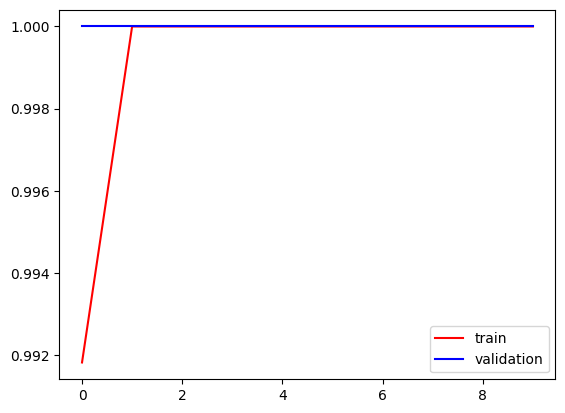

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], color="red", label="train")
plt.plot(history.history["val_accuracy"], color="blue", label="validation")
plt.legend()
plt.show()

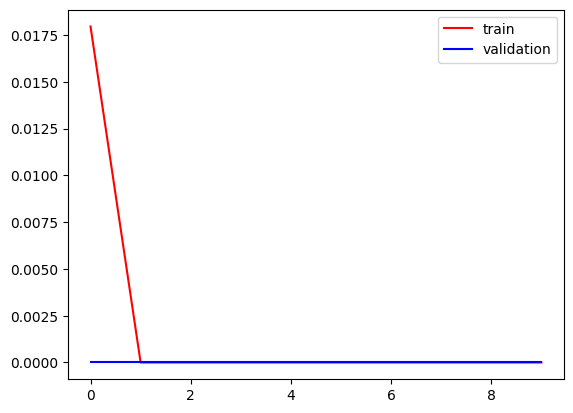

In [9]:
plt.plot(history.history["loss"], color="red", label="train")
plt.plot(history.history["val_loss"], color="blue", label="validation")
plt.legend()
plt.show()

# CNN after reducing Over-Fitting

In [10]:
from keras.layers import BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu", input_shape=(256,256,3)))
model.add(BatchNormalization()) # reduce the internal covariate shift that can occur during training.
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

model.add(Conv2D(64, kernel_size=(3,3), padding="valid", activation="relu", input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

model.add(Conv2D(128, kernel_size=(3,3), padding="valid", activation="relu", input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1)) # works by randomly dropping out neurons during training, which forces the network to learn more robust features
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

In [12]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_ds, epochs=5, validation_data=validation_ds)

Epoch 1/5


39/39 [==============================] - 139s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 72.7865 - val_accuracy: 0.0000e+00
Epoch 2/5
39/39 [==============================] - 140s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 60.7881 - val_accuracy: 0.0000e+00
Epoch 3/5
39/39 [==============================] - 132s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 36.5942 - val_accuracy: 0.0333
Epoch 4/5
39/39 [==============================] - 124s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 13.0773 - val_accuracy: 0.5333
Epoch 5/5
39/39 [==============================] - 121s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.2249 - val_accuracy: 0.7952


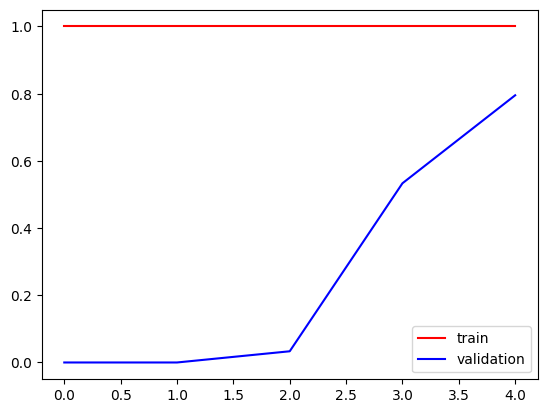

In [13]:
plt.plot(history.history["accuracy"], color="red", label="train")
plt.plot(history.history["val_accuracy"], color="blue", label="validation")
plt.legend()
plt.show()

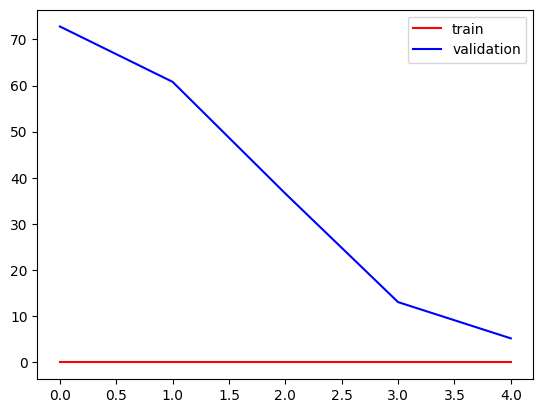

In [14]:
plt.plot(history.history["loss"], color="red", label="train")
plt.plot(history.history["val_loss"], color="blue", label="validation")
plt.legend()
plt.show()

In [15]:
model.metrics_names

['loss', 'accuracy']

# Custom Dataset Creation

In [25]:
np.random.seed(1234)

In [26]:
X = []
y = []

path = "./Training/Tumor_Cropped/"
images = os.listdir(path)
for img in images:
    img_arr = cv2.imread(os.path.join(path, img))
    image = cv2.resize(img_arr, (300, 300), interpolation=cv2.INTER_CUBIC)
    image = image / 255
    X.append(image)
    y.append(1)

# TRAINING NON TUMOR
path = "./Training/Non_Tumor_Cropped/"
images = os.listdir(path)
for img in images:
    img_arr = cv2.imread(os.path.join(path, img))
    image = cv2.resize(img_arr, (300, 300), interpolation=cv2.INTER_CUBIC)
    image = image / 255
    X.append(image)
    y.append(0)

# TESTING TUMOR
path = "./Testing/Tumor_Cropped/"
images = os.listdir(path)
for img in images:
    img_arr = cv2.imread(os.path.join(path, img))
    image = cv2.resize(img_arr, (300, 300), interpolation=cv2.INTER_CUBIC)
    image = image / 255
    X.append(image)
    y.append(1)

# TESTING NON TUMOR
path = "./Testing/Non_Tumor_Cropped/"
images = os.listdir(path)
for img in images:
    img_arr = cv2.imread(os.path.join(path, img))
    image = cv2.resize(img_arr, (300, 300), interpolation=cv2.INTER_CUBIC)
    image = image / 255
    X.append(image)
    y.append(0)

X = np.array(X)
y = np.array(y)

X, y = shuffle(X, y)

print(X.shape, y.shape)

' X = []\ny = []\n\n# TRAINING TUMOR\npath = "/content/drive/MyDrive/Brain_tumor_images/Training/Tumor_Cropped/"\nimages = os.listdir(path)\nfor img in images:\n    img_arr = cv2.imread(os.path.join(path, img))\n    image = cv2.resize(img_arr, (300, 300), interpolation=cv2.INTER_CUBIC)\n    image = image / 255\n    # np.append(X, image, axis=0)\n    # np.append(y, 1, axis=0)\n    X.append(image)\n    y.append(1)\n\n# TRAINING NON TUMOR\npath = "/content/drive/MyDrive/Brain_tumor_images/Training/Non_Tumor_Cropped/"\nimages = os.listdir(path)\nfor img in images:\n    img_arr = cv2.imread(os.path.join(path, img))\n    image = cv2.resize(img_arr, (300, 300), interpolation=cv2.INTER_CUBIC)\n    image = image / 255\n    # np.append(X, image, axis=0)\n    # np.append(y, 1, axis=0)\n    X.append(image)\n    y.append(0)\n\n# TESTING TUMOR\npath = "/content/drive/MyDrive/Brain_tumor_images/Testing/Tumor_Cropped/"\nimages = os.listdir(path)\nfor img in images:\n    img_arr = cv2.imread(os.path.jo

In [27]:
# with open("/content/drive/MyDrive/X_DF.npy", "wb") as f:
#     np.save(f, X)
# with open("/content/drive/MyDrive/y_DF.npy", "wb") as f:
#     np.save(f, y)

In [18]:
with open("./X_DF.npy", "rb") as f:
    X = np.load(f)
with open("./y_DF.npy", "rb") as f:
    y = np.load(f)

# CNN - Another Method

- Training: 70% of sample data
- Testing: 15% of sample data
- Validation: 15% of sample data

In [19]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3) # CHANGE IT
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1002
number of development examples = 215
number of test examples = 215
X_train shape: (1002, 300, 300, 3)
Y_train shape: (1002,)
X_val (dev) shape: (215, 300, 300, 3)
Y_val (dev) shape: (215,)
X_test shape: (215, 300, 300, 3)
Y_test shape: (215,)


In [20]:
from keras.layers import BatchNormalization, Dropout
from keras import Sequential

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu", input_shape=(300,300,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

model.add(Conv2D(64, kernel_size=(3,3), padding="valid", activation="relu", input_shape=(300,300,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

model.add(Conv2D(128, kernel_size=(3,3), padding="valid", activation="relu", input_shape=(300,300,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="valid"))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 298, 298, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 149, 149, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 147, 147, 64)      256       
 chNormalization)                                                
                                                      

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'./Logs/{log_file_name}')

# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"

# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("./Models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [22]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"


def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [23]:
# EPOCH = 10

start_time = time.time()

model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 6.5671 - accuracy: 0.8184INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-01-0.80.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-01-0.80.model\assets


32/32 [==============================] - 169s 5s/step - loss: 6.5671 - accuracy: 0.8184 - val_loss: 0.9908 - val_accuracy: 0.7953
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 3.4866 - accuracy: 0.8842INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-02-0.84.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-02-0.84.model\assets


32/32 [==============================] - 166s 5s/step - loss: 3.4866 - accuracy: 0.8842 - val_loss: 1.2719 - val_accuracy: 0.8419
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 2.3173 - accuracy: 0.9052INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-03-0.78.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-03-0.78.model\assets


32/32 [==============================] - 148s 5s/step - loss: 2.3173 - accuracy: 0.9052 - val_loss: 3.2760 - val_accuracy: 0.7814
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 1.7884 - accuracy: 0.9062INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-04-0.67.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-04-0.67.model\assets


32/32 [==============================] - 150s 5s/step - loss: 1.7884 - accuracy: 0.9062 - val_loss: 11.7763 - val_accuracy: 0.6698
Epoch 5/10
32/32 [==============================] - ETA: 0s - loss: 1.0708 - accuracy: 0.9182INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-05-0.67.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-05-0.67.model\assets


32/32 [==============================] - 157s 5s/step - loss: 1.0708 - accuracy: 0.9182 - val_loss: 10.2291 - val_accuracy: 0.6698
Epoch 6/10
32/32 [==============================] - ETA: 0s - loss: 0.8780 - accuracy: 0.9182INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-06-0.67.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-06-0.67.model\assets


32/32 [==============================] - 142s 4s/step - loss: 0.8780 - accuracy: 0.9182 - val_loss: 9.0574 - val_accuracy: 0.6651
Epoch 7/10
32/32 [==============================] - ETA: 0s - loss: 0.8013 - accuracy: 0.9251INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-07-0.82.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-07-0.82.model\assets


32/32 [==============================] - 139s 4s/step - loss: 0.8013 - accuracy: 0.9251 - val_loss: 1.9656 - val_accuracy: 0.8233
Epoch 8/10
32/32 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.9311INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-08-0.78.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-08-0.78.model\assets


32/32 [==============================] - 137s 4s/step - loss: 0.5256 - accuracy: 0.9311 - val_loss: 3.9504 - val_accuracy: 0.7814
Epoch 9/10
32/32 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.9401INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-09-0.71.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-09-0.71.model\assets


32/32 [==============================] - 172s 5s/step - loss: 0.6023 - accuracy: 0.9401 - val_loss: 1.5853 - val_accuracy: 0.7116
Epoch 10/10
32/32 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.9202INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-10-0.78.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-10-0.78.model\assets


32/32 [==============================] - 158s 5s/step - loss: 0.6242 - accuracy: 0.9202 - val_loss: 1.5111 - val_accuracy: 0.7767
Elapsed time: 0:25:49.5


In [24]:
# EPOCH = 3

start_time = time.time()

model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=3,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
32/32 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.9411INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-01-0.85.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-01-0.85.model\assets


32/32 [==============================] - 164s 5s/step - loss: 0.4268 - accuracy: 0.9411 - val_loss: 1.1488 - val_accuracy: 0.8465
Epoch 2/3
32/32 [==============================] - ETA: 0s - loss: 0.3674 - accuracy: 0.9461INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-02-0.93.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-02-0.93.model\assets


32/32 [==============================] - 185s 6s/step - loss: 0.3674 - accuracy: 0.9461 - val_loss: 0.8287 - val_accuracy: 0.9256
Epoch 3/3
32/32 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.9481INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-03-0.85.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-03-0.85.model\assets


32/32 [==============================] - 300s 9s/step - loss: 0.3210 - accuracy: 0.9481 - val_loss: 2.2809 - val_accuracy: 0.8465
Elapsed time: 0:10:56.0


In [25]:
# EPOCH = 5

start_time = time.time()

model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[tensorboard, checkpoint]
)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.9491INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-01-0.90.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-01-0.90.model\assets


32/32 [==============================] - 250s 8s/step - loss: 0.2860 - accuracy: 0.9491 - val_loss: 1.2434 - val_accuracy: 0.8977
Epoch 2/5
32/32 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.9331INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-02-0.93.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-02-0.93.model\assets


32/32 [==============================] - 156s 5s/step - loss: 0.2804 - accuracy: 0.9331 - val_loss: 0.6509 - val_accuracy: 0.9256
Epoch 3/5
32/32 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.9471INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-03-0.96.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-03-0.96.model\assets


32/32 [==============================] - 163s 5s/step - loss: 0.3057 - accuracy: 0.9471 - val_loss: 0.1674 - val_accuracy: 0.9581
Epoch 4/5
32/32 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.9391INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-04-0.95.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-04-0.95.model\assets


32/32 [==============================] - 151s 5s/step - loss: 0.2968 - accuracy: 0.9391 - val_loss: 0.3554 - val_accuracy: 0.9488
Epoch 5/5
32/32 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.9551INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-05-0.98.model\assets


INFO:tensorflow:Assets written to: ./Models\cnn-parameters-improvement-05-0.98.model\assets


32/32 [==============================] - 154s 5s/step - loss: 0.2804 - accuracy: 0.9551 - val_loss: 0.2300 - val_accuracy: 0.9767
Elapsed time: 0:14:44.6


In [26]:
history = model.history.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

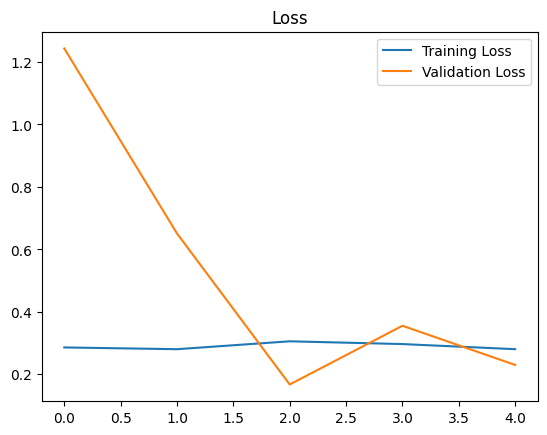

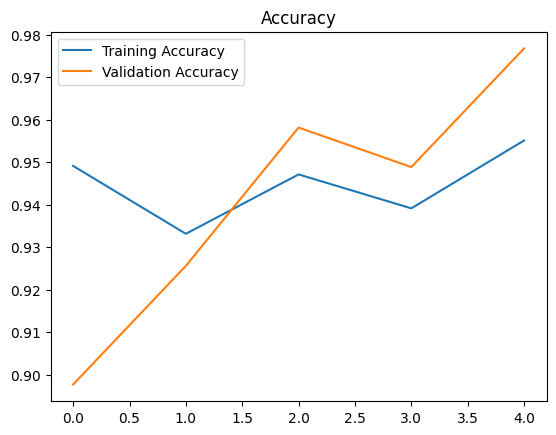

In [27]:
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# CNN - Best Fit Model

In [28]:
best_model = load_model(filepath='./Models/cnn-parameters-improvement-05-0.98.model/')

In [29]:
best_model.metrics_names
loss, accuracy = best_model.evaluate(x=X_test, y=y_test)

7/7 [==============================] - 7s 803ms/step - loss: 0.2027 - accuracy: 0.9814


In [30]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.2027350813150406
Test Accuracy = 0.9813953638076782


In [31]:
y_test_prob = best_model.predict(X_test)
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

7/7 [==============================] - 6s 793ms/step
F1 score: 0.9852941176470589


In [32]:
y_val_prob = best_model.predict(X_val)
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

7/7 [==============================] - 7s 951ms/step
F1 score: 0.9819494584837546


In [33]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

# the whole data
data_percentage(y)

print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Number of examples: 1432
Percentage of positive examples: 65.08379888268156%, number of pos examples: 932
Percentage of negative examples: 34.91620111731844%, number of neg examples: 500
Training Data:
Number of examples: 1002
Percentage of positive examples: 65.6686626746507%, number of pos examples: 658
Percentage of negative examples: 34.3313373253493%, number of neg examples: 344
Validation Data:
Number of examples: 215
Percentage of positive examples: 63.72093023255814%, number of pos examples: 137
Percentage of negative examples: 36.27906976744186%, number of neg examples: 78
Testing Data:
Number of examples: 215
Percentage of positive examples: 63.72093023255814%, number of pos examples: 137
Percentage of negative examples: 36.27906976744186%, number of neg examples: 78


In [41]:
y_test_prob = [1 if i>=0.5 else 0 for i in y_test_prob]
# y_test_prob

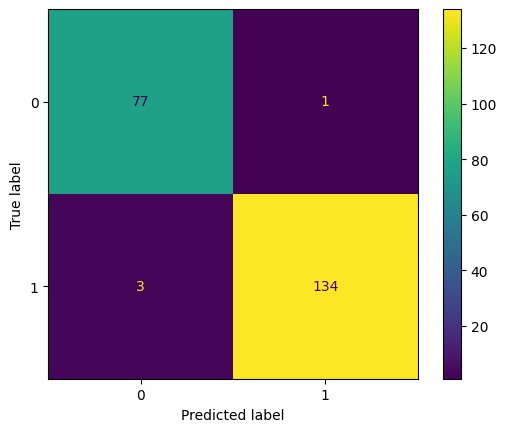

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

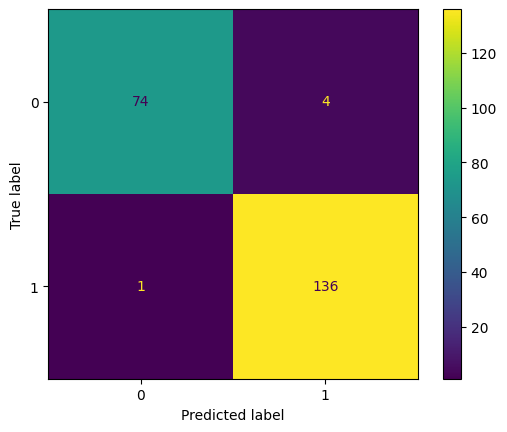

In [46]:
y_val_prob = [1 if i>=0.5 else 0 for i in y_val_prob]
cm = confusion_matrix(y_val, y_val_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()